<a href="https://colab.research.google.com/github/ideamanjo/Machine_Learning/blob/master/Team2_CNN_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

In [0]:
import tensorflow.keras.layers as Layers
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer

import os
import matplotlib.pyplot as plot
import seaborn as sns
import pandas as pd
import cv2
import numpy as np
import scipy

from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from random import randint
from tqdm import tqdm_notebook as tqdm

In [0]:
import matplotlib.pyplot as plt 
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.gridspec as gridspec

Using TensorFlow backend.


In [0]:
def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

# 1. Train/Test Image Load

In [0]:
def get_images():
    # read train, test images
    # make it imbalance
    # then merge, shuffle, split
    
    dir_train = './seg_train3'
    
    label_str_to_int = {
        'buildings': 0,
        'forest': 1,
        'glacier': 2,
        'mountain': 3,
        'sea': 4,
        'street': 5,
    }
    
    train_images = []
    train_labels = []
    
    for label_str in tqdm(os.listdir(dir_train), desc='dir', leave=False):
        label_int = label_str_to_int[label_str]
        image_dir = os.path.join(dir_train, label_str)
        
        for image_file in tqdm(os.listdir(image_dir), desc='images', leave=False):
            image = cv2.imread(os.path.join(image_dir, image_file)) # Read image.
            image = cv2.resize(image, (150, 150)) # Resize images. Some images are different sizes.
            train_images.append(image)
            train_labels.append(label_int)
   
    x_train, y_train = shuffle(train_images, train_labels)
    
    return np.array(x_train), np.array(y_train) #, np.array(x_test), np.array(y_test)

In [0]:
x_train, y_train = get_images()

In [0]:

def get_images_test():
    # read train, test images
    # make it imbalance
    # then merge, shuffle, split
    
    dir_test = './seg_test/files'
    
    test_images = []
    test_filename = []
    
    image_dir = os.path.join(dir_test)
       
    for image_file in tqdm(os.listdir(image_dir), desc='images', leave=False):
        image = cv2.imread(os.path.join(image_dir, image_file)) # Read image.
        image = cv2.resize(image, (150, 150)) # Resize images. Some images are different sizes.
        test_images.append(image)
        #test_labels.append(label_int)
        test_filename.append(int(image_file.split('.')[0]))
                
    x_test, x_test_filename = shuffle(test_images, test_filename)
                
    return np.array(x_test) , np.array(x_test_filename)

In [0]:
x_test, test_filename = get_images_test()

In [0]:
df_filename = pd.DataFrame(test_filename, columns=['filename'])
df_filename.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3604 entries, 0 to 3603
Data columns (total 1 columns):
filename    3604 non-null int64
dtypes: int64(1)
memory usage: 28.2 KB


In [0]:
print(x_train.shape, y_train.shape)
print(x_test.shape)

(61448, 150, 150, 3) (61448,)
(3604, 150, 150, 3)


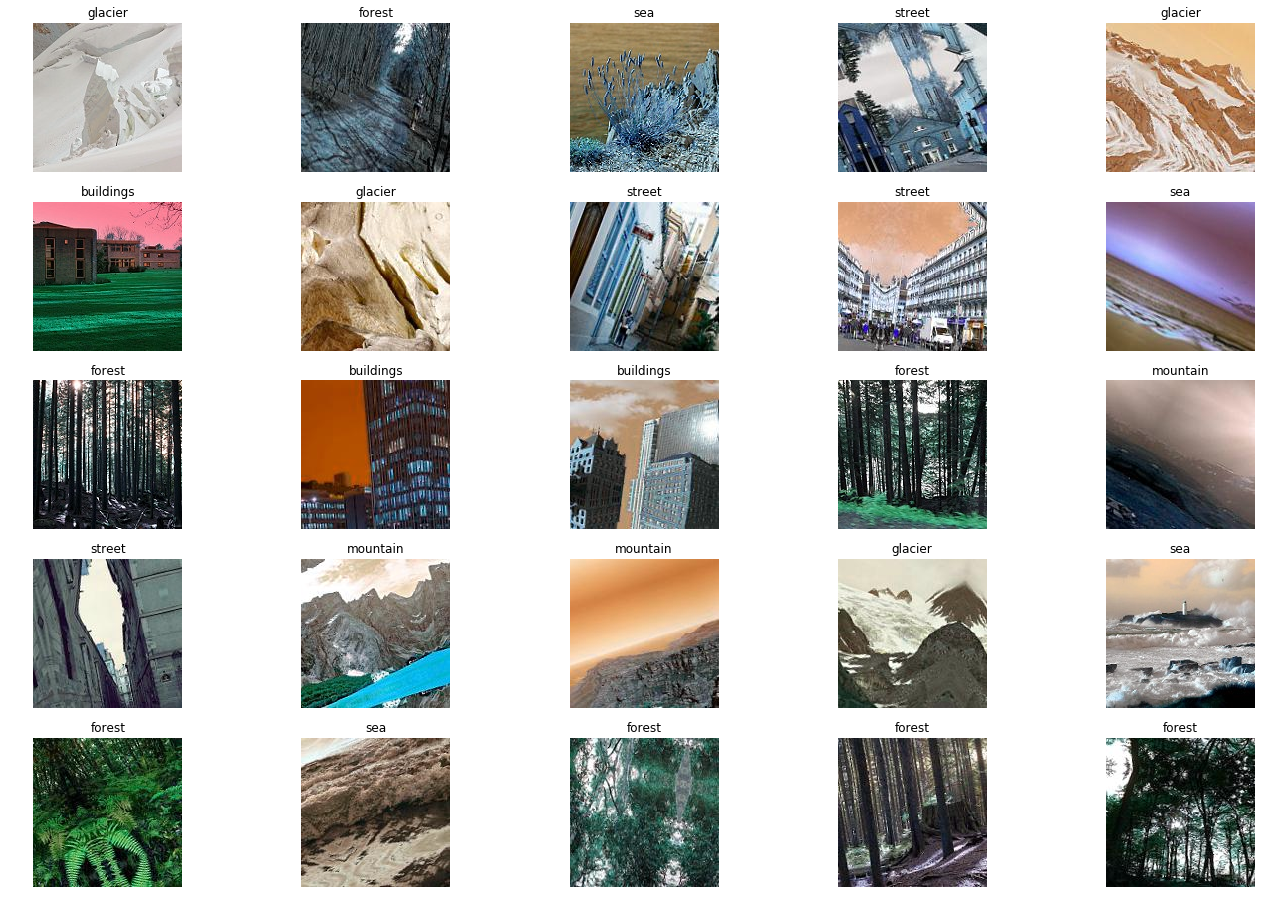

In [0]:
# some images
f, ax = plot.subplots(5, 5) 
f.subplots_adjust(0, 0, 3, 3)
for i in range(0, 5, 1):
    for j in range(0, 5, 1):
        rnd_number = randint(0, x_train.shape[0])
        ax[i, j].imshow(x_train[rnd_number])
        ax[i, j].set_title(get_classlabel(y_train[rnd_number]))
        ax[i, j].axis('off')

In [0]:
print ("Number of training examples: " + str(y_train.shape[0]))
print ("Each image is of size: " + str(x_train.shape[1:]))

print ("Number of testing examples: " + str(x_test.shape[0]))
print ("Each image is of size: " + str(x_test.shape[1:]))

Number of training examples: 61448
Each image is of size: (150, 150, 3)
Number of testing examples: 3604
Each image is of size: (150, 150, 3)


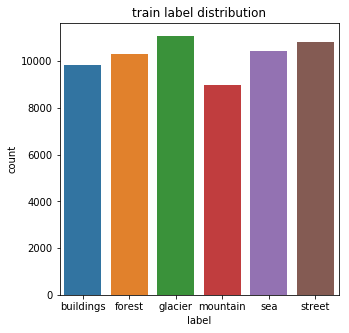

In [0]:
# label distribution
train_label_str = [get_classlabel(label_int) for label_int in y_train.tolist()]

labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

df_train_label = pd.DataFrame(train_label_str, columns=['label'])

f, ax = plot.subplots(1, 1, figsize=(5, 5))
sns.countplot(x='label', data=df_train_label, ax=ax, order=labels)
ax.set_title('train label distribution')

plot.show()


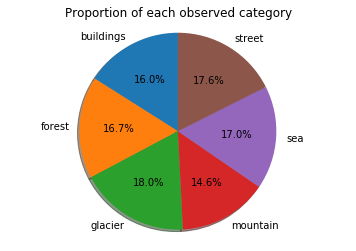

In [0]:
# Plot a pie chart
sizes = np.bincount(y_train)
explode = (0, 0, 0, 0, 0, 0)  
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Proportion of each observed category')

plt.show()

In [0]:
x_train = x_train / 255.0 
x_test = x_test / 255.0

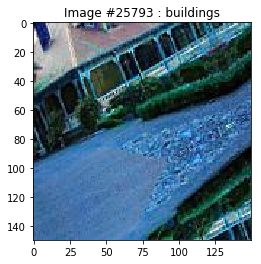

In [0]:
index = np.random.randint(x_train.shape[0])
plt.figure()
plt.imshow(x_train[index])
plt.grid(False)
plt.title('Image #{} : '.format(index) + labels[y_train[index]])
plt.show()

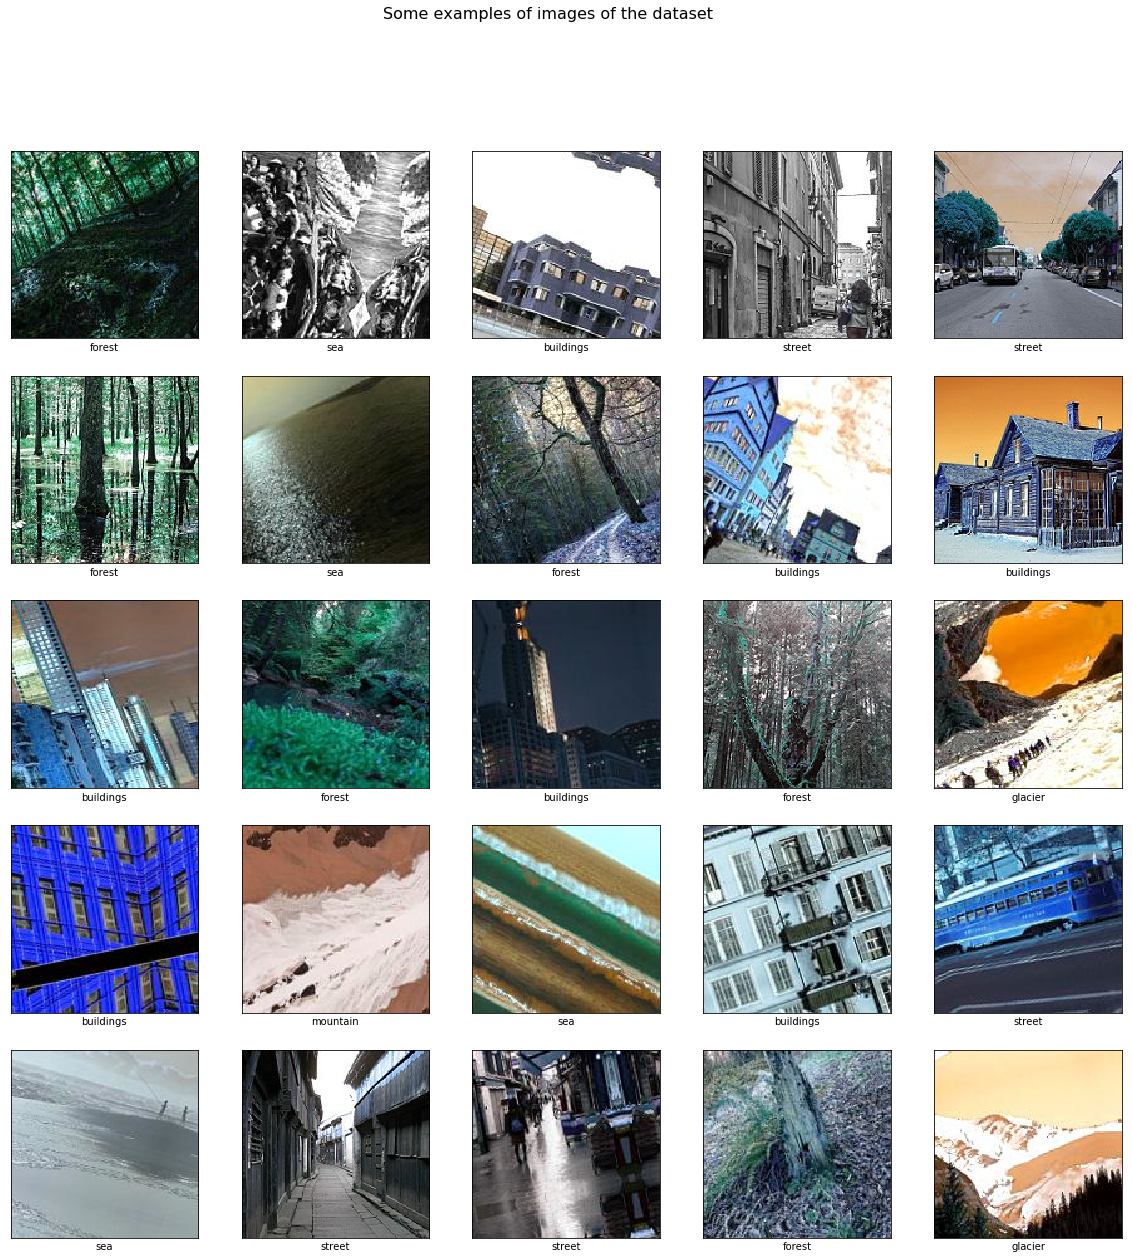

In [0]:
fig = plt.figure(figsize=(20,20))
fig.suptitle("Some examples of images of the dataset", fontsize=16)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(labels[y_train[i]])
plt.show()

# CNN 모델 정의

Transfer Learning으로 tensorflow.keras.applications의 미리 학습된 모델 8개와
직접 구현한 mycnn, mycnn2 2개 모델 총 11개를 사용하여 Ensemble 진행 함
(mountain의 F1 score가 낮아 mountain의 정합성을 향상시키기 위해 mobilenet 모델은 2번 사용)

In [0]:
from tensorflow.keras.layers import Input,Dropout, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model, load_model,Sequential
from tensorflow.keras.initializers import glorot_uniform

In [0]:
#from keras.applications import *
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
#from keras.layers import *
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [0]:
def model_mycnn():   
    model = Sequential()

    model.add(Conv2D(64,kernel_size=(3,3),activation='relu', padding='same',input_shape=(150,150,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(3,3))
    model.add(Dropout(rate=0.3))

    model.add(Conv2D(128,kernel_size=(3,3),activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,kernel_size=(3,3),activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(3,3))
    model.add(Dropout(rate=0.3))

    model.add(Conv2D(256,kernel_size=(3,3),activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,kernel_size=(3,3),activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(3,3))
    model.add(Dropout(rate=0.3))

    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))
    model.add(Dense(6,activation='softmax'))

    model.compile(optimizer=Optimizer.Adam(lr=0.0009),loss='sparse_categorical_crossentropy',metrics=['accuracy'])


    return model

In [0]:
def model_mycnn2():   
    model = Sequential()

    model.add(Conv2D(64,kernel_size=(3,3),activation='relu', padding='same',input_shape=(150,150,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(3,3))
    model.add(Dropout(rate=0.3))

    model.add(Conv2D(128,kernel_size=(3,3),activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,kernel_size=(3,3),activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(3,3))
    model.add(Dropout(rate=0.3))

    model.add(Flatten())

    model.add(Dense(512,activation='relu'))

    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))
    model.add(Dense(6,activation='softmax'))

    model.compile(optimizer=Optimizer.Adam(lr=0.0009),loss='sparse_categorical_crossentropy',metrics=['accuracy'])


    return model

In [0]:
def model_xception():
    # Load the pretrained model
    model_xception = Xception(include_top=False, weights='imagenet', input_shape=(150, 150, 3,), pooling=None)

    # Building the model
    xception_output = model_xception.output

    fc1 = Flatten()(xception_output)
    fc1 = Dense(2048, activation='relu')(fc1)
    fc1_dropout = Dropout(0.3)(fc1)
    fc2 = Dense(256, activation='relu')(fc1_dropout)
    fc2_dropout = Dropout(0.3)(fc2)
    output = Dense(6, activation='softmax')(fc2_dropout)
    model = Model(model_xception.input, output)
    
  
    
    # Set the pretrained model to be non trainable
    model.layers[0].trainable = False
        
    #model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
        
    return model

In [0]:
def model_dense():   
    dense121 = DenseNet121(include_top=False, weights='imagenet', input_shape = (150,150,3))
    dense121.trainable=False
    for layer in dense121.layers[:-4]:
        layer.trainable = False

    dense_output = dense121.output

    fc1 = Flatten()(dense_output)
    fc1 = Dense(2048, activation='relu')(fc1)
    fc1_dropout = Dropout(0.3)(fc1)
    fc2 = Dense(512, activation='relu')(fc1)
    fc2_dropout = Dropout(0.3)(fc2)
    fc3 = Dense(128, activation='relu')(fc2_dropout)
    fc3_dropout = Dropout(0.3)(fc3)
    output = Dense(6, activation='softmax')(fc3_dropout)
    model = Model(dense121.input, output)

    # Compile the model with loss and metrics
    model.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    
    
    return model

In [0]:
def model_vgg16():
    vgg16 = VGG16(input_shape=(150,150,3), include_top=False, weights="imagenet" )

    for layer in vgg16.layers:
        layer.trainable=False
        
    model = tf.keras.models.Sequential([
        vgg16,

        Flatten(),
        #Dense(2048,activation="relu"),
        #BatchNormalization(),
        #Dropout(0.5),

        Dense(512,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),

        Dense(512,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(6, activation='softmax')
    ])
        
    model.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])    
    
    return model

In [0]:
def model_vgg19():
    vgg19 = VGG19(input_shape=(150,150,3), include_top=False, weights="imagenet" )

    for layer in vgg19.layers:
        layer.trainable=False

    model = tf.keras.models.Sequential([
        vgg19,

        Flatten(),
        #Dense(2048,activation="relu"),
        #BatchNormalization(),
        #Dropout(0.5),

        Dense(512,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),

        Dense(512,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(6, activation='softmax')
    ])
    
    model.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])    
    
    return model

In [0]:
def model_mobile():
    #mobile_model = tf.keras.applications.MobileNet(input_shape=(150, 150, 3), include_top=False)
    mobile_model = MobileNet(input_shape=(150, 150, 3), include_top=False)
    mobile_model.trainable = True
        
    fine_tune_at = 100
    for layer in mobile_model.layers[:fine_tune_at]:
        layer.trainable =  False
    model = tf.keras.Sequential([
        mobile_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
        

    model.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])    
    
    return model

In [0]:
def model_mobileV2():
    mobilev2_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False)
    mobilev2_model.trainable = True
    
    fine_tune_at = 100
    for layer in mobilev2_model.layers[:fine_tune_at]:
        layer.trainable =  False
    model = tf.keras.Sequential([
        mobilev2_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
        
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    
    return model

In [0]:
def model_res50():
    res50 = ResNet50V2(include_top=False, weights='imagenet', input_shape = (150,150,3))
        
    res50.trainable=False
    for layer in res50.layers[:-4]:
        layer.trainable = False

    res_output = res50.output

    fc1 = Flatten()(res_output)
    fc1 = Dense(512, activation='relu')(fc1)
    fc1_dropout = Dropout(0.3)(fc1)
    fc2 = Dense(128, activation='relu')(fc1_dropout)
    fc2_dropout = Dropout(0.3)(fc2)
    output = Dense(6, activation='softmax')(fc2_dropout)
    model = Model(res50.input, output)
        
    model.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    #model.compile(optimizer=Optimizer.SGD(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
        
    return model

In [0]:
def model_res101():
    model_res101 = ResNet101V2(include_top=False, weights='imagenet', input_shape = (150,150,3))
    
    model_res101.trainable=False
    for layer in model_res101.layers[:-4]:
        layer.trainable = False

    res_output = model_res101.output

    fc1 = Flatten()(res_output)
    fc1 = Dense(2048, activation='relu')(fc1)
    fc1_dropout = Dropout(0.3)(fc1)
    fc2 = Dense(256, activation='relu')(fc1_dropout)
    fc2_dropout = Dropout(0.3)(fc2)
    output = Dense(6, activation='softmax')(fc2_dropout)
    model = Model(model_res101.input, output)
        
    model.compile(optimizer=Optimizer.SGD(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
        
    return model

In [0]:
def model_inception():
    # create the base pre-trained model
    model_inception = InceptionV3(input_shape=(150, 150, 3), weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = model_inception.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(6, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=model_inception.input, outputs=predictions)

    for layer in model_inception.layers[:249]:
        layer.trainable = False
    for layer in model_inception.layers[249:]:
        layer.trainable = True

    model.compile(optimizer=Optimizer.SGD(lr=0.001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Ensemble

In [0]:
model = []
model.append(model_xception())
model.append(model_mycnn())
model.append(model_mycnn2())
model.append(model_dense())
model.append(model_vgg16())
model.append(model_vgg19())
model.append(model_mobile())
model.append(model_mobile())
model.append(model_mobileV2())
model.append(model_res50())
model.append(model_inception())

/home/ds4user6/.local/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
/home/ds4user6/.local/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
/home/ds4user6/.local/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [0]:
# Start multiple model training with the batch size
models = []
for i in range(len(model)):
    print('starting... : ' , i)
    model[i].fit(x_train,y_train, batch_size=64, epochs = 10, validation_split=0.2)
    models.append(model[i])
    print('finished... : ' , i)

starting... :  0
Train on 49158 samples, validate on 12290 samples
Epoch 1/10
49158/49158 [==============================] - 311s 6ms/sample - loss: 0.4632 - acc: 0.8317 - val_loss: 0.2730 - val_acc: 0.9003
Epoch 2/10
49158/49158 [==============================] - 281s 6ms/sample - loss: 0.2138 - acc: 0.9225 - val_loss: 0.3458 - val_acc: 0.8797
Epoch 3/10
49158/49158 [==============================] - 281s 6ms/sample - loss: 0.1384 - acc: 0.9501 - val_loss: 0.1717 - val_acc: 0.9398
Epoch 4/10
49158/49158 [==============================] - 282s 6ms/sample - loss: 0.0839 - acc: 0.9700 - val_loss: 0.1799 - val_acc: 0.9404
Epoch 5/10
49158/49158 [==============================] - 281s 6ms/sample - loss: 0.0528 - acc: 0.9817 - val_loss: 0.3332 - val_acc: 0.8980
Epoch 6/10
49158/49158 [==============================] - 282s 6ms/sample - loss: 0.0379 - acc: 0.9875 - val_loss: 0.8234 - val_acc: 0.8269
Epoch 7/10
49158/49158 [==============================] - 282s 6ms/sample - loss: 0.0276 - ac

In [0]:
'''
model_xception()
model_mycnn()
model_mycnn2()
model_dense()
model_vgg16()
model_vgg19()
model_mobile()
model_mobile()
model_mobileV2()
model_res50()
model_inception()
'''

In [0]:
models

In [0]:
# Predict labels with models
labels = []
for m in models:
    predicts = np.argmax(m.predict(x_test), axis=1)
    labels.append(predicts)
    

In [0]:
labels

[array([1, 1, 2, ..., 0, 1, 3]),
 array([4, 1, 2, ..., 0, 1, 3]),
 array([4, 1, 2, ..., 0, 1, 2]),
 array([4, 1, 2, ..., 0, 1, 3]),
 array([3, 1, 2, ..., 0, 1, 2]),
 array([4, 1, 2, ..., 5, 1, 2]),
 array([3, 1, 2, ..., 5, 1, 3]),
 array([3, 1, 2, ..., 0, 1, 3]),
 array([4, 1, 2, ..., 0, 1, 2]),
 array([3, 1, 2, ..., 0, 1, 3]),
 array([4, 1, 2, ..., 0, 1, 2])]

In [0]:
# Ensemble with voting
labels = np.array(labels)
labels = np.transpose(labels, (1, 0))
labels = scipy.stats.mode(labels, axis=-1)[0]
labels = np.squeeze(labels)

In [0]:
labels

array([4, 1, 2, ..., 0, 1, 3])

In [0]:
pred_class = []
for i in range(len(labels)):
    pred_class.append(get_classlabel(labels[i]))

In [0]:
pred_class

['sea',
 'forest',
 'glacier',
 'glacier',
 'street',
 'street',
 'buildings',
 'sea',
 'glacier',
 'sea',
 'street',
 'glacier',
 'street',
 'sea',
 'glacier',
 'forest',
 'street',
 'street',
 'street',
 'glacier',
 'glacier',
 'buildings',
 'forest',
 'buildings',
 'forest',
 'forest',
 'glacier',
 'forest',
 'street',
 'glacier',
 'buildings',
 'sea',
 'sea',
 'forest',
 'forest',
 'street',
 'glacier',
 'buildings',
 'sea',
 'sea',
 'street',
 'sea',
 'glacier',
 'mountain',
 'street',
 'buildings',
 'glacier',
 'buildings',
 'street',
 'street',
 'sea',
 'sea',
 'glacier',
 'buildings',
 'street',
 'glacier',
 'glacier',
 'forest',
 'glacier',
 'sea',
 'buildings',
 'glacier',
 'forest',
 'street',
 'street',
 'street',
 'street',
 'street',
 'buildings',
 'forest',
 'forest',
 'street',
 'sea',
 'forest',
 'street',
 'glacier',
 'forest',
 'forest',
 'forest',
 'glacier',
 'forest',
 'street',
 'street',
 'forest',
 'glacier',
 'street',
 'glacier',
 'mountain',
 'buildings',
 '

In [0]:
df_filename.head(10)

,filename
0,11034
1,12913
2,7860
3,6193
4,13896
5,14185
6,693
7,13539
8,2725
9,13156


In [0]:
df_filename['prediction'] =  pred_class
sol = df_filename.sort_values(by=['filename'], axis=0)

In [0]:
sol.head(10)

,filename,prediction
3081,8,buildings
1122,13,mountain
1286,18,street
1449,31,street
726,43,mountain
228,57,street
620,60,sea
1735,68,street
1128,78,glacier
1385,82,street


In [0]:
sol.to_csv("test.csv",index=False)